## Energy_Consumption_Analysis

Goal: Building a model that predicts electricity consumption, located in the KWH field in the dataset

##Methodology


1.   Data understanding
    *  Data exploration 
2.   Data preparation
    *  One-Hot Encoding the categorical columns
    *  Handling NaN values
    *  Removing the unneacesary columns
       *  Assumptions and considerations:
            *   Columns starting with 'Z' are the imputation flags for other variables. So are to be removed as they will not contrubute in the prediction.
            *   Columns with thermal unit other than KWH are assumend to be not helpful. Hence are removed. 
            *   Columns which show the total consumptions of elements' electricity usage are redundant as the individual contributions by those elements are already present in the data. Hence are removed for avoiding data redundancy.
3.   Data Analysis
    * Finding the correlation of features with output variable and visualizing
4.   Random Forest Regressor
    *  Using GridSearchCV for selecting optimal hyperparameters for the model
    *  Choosing important features by calculating feature importances

## Conclusion <br>

##Further Tasks <br>
##References <br>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#1. Data understanding

Importing the Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns

Loading the data

In [ ]:
# Loading dataset
PATH_data_layout = "/public_layout.csv"
PATH_data_public = "/recs2009_public.csv"
PATH_data_codebook = "/recs2009_public_codebook.csv"

data_layout = pd.read_csv(PATH_data_layout, sep=',', low_memory=False) 
data_public = pd.read_csv(PATH_data_public, sep=',', low_memory=False) 
data_codebook = pd.read_csv(PATH_data_codebook, sep=',', low_memory=False) 

Looking into the data

In [ ]:
data_public.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12083 entries, 0 to 12082
Data columns (total 940 columns):
 #    Column              Dtype  
---   ------              -----  
 0    DOEID               int64  
 1    REGIONC             int64  
 2    DIVISION            int64  
 3    REPORTABLE_DOMAIN   int64  
 4    TYPEHUQ             int64  
 5    NWEIGHT             float64
 6    HDD65               int64  
 7    CDD65               int64  
 8    HDD30YR             int64  
 9    CDD30YR             int64  
 10   Climate_Region_Pub  int64  
 11   AIA_Zone            int64  
 12   METROMICRO          object 
 13   UR                  object 
 14   KOWNRENT            int64  
 15   CONDCOOP            int64  
 16   YEARMADE            int64  
 17   YEARMADERANGE       int64  
 18   OCCUPYYRANGE        int64  
 19   CONVERSION          int64  
 20   ORIG1FAM            int64  
 21   LOOKLIKE            int64  
 22   NUMFLRS             int64  
 23   NUMAPTS             int64  
 24   

In [ ]:
data_public.shape

(12083, 940)

In [ ]:
data_layout.head()

,Variable Name,Variable Label,Variable Order in File,Variable Type,Length
0,DOEID,Unique identifier for each respondent,1,Character,5
1,REGIONC,Census Region,2,Numeric,8
2,DIVISION,Census Division,3,Numeric,8
3,REPORTABLE_DOMAIN,Reportable states and groups of states,4,Numeric,8
4,TYPEHUQ,Type of housing unit,5,Numeric,8


In [ ]:
data_cols = data_layout.columns
data_cols

Index(['Variable Name', 'Variable Label', 'Variable Order in File',
       'Variable Type', 'Length'],
      dtype='object')

# 2. Data Preparation

In [ ]:
# Find the columns with datatype as category and object

def cat_or_obj(df):
  category_columns = df.select_dtypes(include=['category']).columns.tolist()
  object_columns = df.select_dtypes(include=['object']).columns.tolist()
  print("Categorical columns:" , category_columns )
  print("Object columns:" , object_columns )
  return category_columns, object_columns


cat_col, obj_col = cat_or_obj(data_public)

Categorical columns: []
Object columns: ['METROMICRO', 'UR', 'NOCRCASH', 'NKRGALNC', 'IECC_Climate_Pub']


In [ ]:
# One Hot Encoding the categorical columns

def one_hot_encode(df):
  df = pd.get_dummies(df, columns = df.select_dtypes(include=["object", "category"]).columns.tolist(),  drop_first=True)
  return df

data_public = one_hot_encode(data_public)
data_public.shape

(12083, 978)

In [ ]:
data_public.shape

(12083, 978)

In [ ]:
# Function for finding the NaN columns

def nan_cols(df):
  nan_columns = [n for n in data_public.columns if data_public[n].isnull().any()]
  print("NaN Columns: ", nan_columns)
  return nan_columns

# Function for finding columns with NaN values being greater than 95% of the total values of the column

def majority_nan_cols(df):
  length_of_dataset = len(df)
  col_many_nan = (df.columns[(((df.isna().sum() / length_of_dataset) *100) > 95) == True])
  print("Number of columns with more than 95% NaN values: ", len(col_many_nan))
  return col_many_nan

In [ ]:
# Check for nan columns or values
nan_columns = nan_cols(data_public)  
print(len(nan_columns))

NaN Columns:  []
0


In [ ]:
# Replace -2 with np.nan as the none values are represented as -2 in the data as per the data-codebook

data_public.replace(to_replace = -2, value = np.nan, inplace = True)

Now there are many columns with NaN values. Finding columns with nan values > 95% of the data

In [ ]:
col_many_nan = majority_nan_cols(data_public)

Number of columns with more than 95% NaN values:  72


*   Columns starting with 'Z' are the imputation flags for other variables. So are to be removed as they will not contrubute in the prediction.
*   Columns with thermal unit other than KWH are assumend to be not helpful. Hence are removed. 
*   Columns which show the total consumptions of elements' electricity usage are redundant as the individual contributions by those elements are already present in the data. Hence are removed for avoiding data redundancy.





In [ ]:
# Columns starting with 'Z' are the imputation flags for other variables
columns_z = data_layout.loc[data_layout['Variable Name'].str.contains(pat = '^Z')]['Variable Name'].tolist()

# Variables with differenct thermal unit
columns_BTU_unit = data_layout.loc[data_layout['Variable Label'].str.contains("BTU", case=False)]['Variable Name'].tolist()

# Other Variables havibg total consumption data
columns_similar = ['KWHSPH', 'KWHCOL', 'KWHWTH', 'KWHRFG', 'KWHOTH']

In [ ]:
# Columns to be removed
col_to_remove = columns_BTU_unit + columns_z + col_many_nan.to_list() + columns_similar

In [ ]:
# Function for removing unwanted columns

def del_cols(df, col_to_remove):
  df = df.drop(col_to_remove, axis = 1, inplace=False)
  return df

# Removing the unwanted columns
data_public = del_cols(data_public, col_to_remove)

In [ ]:
data_public.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12083 entries, 0 to 12082
Data columns (total 512 columns):
 #    Column                          Dtype  
---   ------                          -----  
 0    DOEID                           int64  
 1    REGIONC                         int64  
 2    DIVISION                        int64  
 3    REPORTABLE_DOMAIN               int64  
 4    TYPEHUQ                         int64  
 5    NWEIGHT                         float64
 6    HDD65                           int64  
 7    CDD65                           int64  
 8    HDD30YR                         int64  
 9    CDD30YR                         int64  
 10   Climate_Region_Pub              int64  
 11   AIA_Zone                        int64  
 12   KOWNRENT                        int64  
 13   CONDCOOP                        float64
 14   YEARMADE                        int64  
 15   YEARMADERANGE                   int64  
 16   OCCUPYYRANGE                    int64  
 17   CONVERSION

Saving the columns of data_public dataframe

In [ ]:
data_public_columns = data_public.columns

Imputing the NaN values with median values

In [ ]:
# Function for imputing NaN values 

def imputer(df, strategy):
  imputer = SimpleImputer(missing_values = np.nan, strategy = strategy)
  imputer = imputer.fit(df)
  df= imputer.transform(df)
  return df


# Imputing the NaN values with median values
strategy = 'median'
data_public = imputer(data_public, strategy)

In [ ]:
data_public = pd.DataFrame(data_public, columns = data_public_columns)

data_public_clean_original = data_public.copy(deep=True)

In [ ]:
data_public.columns

Index(['DOEID', 'REGIONC', 'DIVISION', 'REPORTABLE_DOMAIN', 'TYPEHUQ',
       'NWEIGHT', 'HDD65', 'CDD65', 'HDD30YR', 'CDD30YR',
       ...
       'IECC_Climate_Pub_2B', 'IECC_Climate_Pub_3A', 'IECC_Climate_Pub_3B-4B',
       'IECC_Climate_Pub_3C', 'IECC_Climate_Pub_4A', 'IECC_Climate_Pub_4C',
       'IECC_Climate_Pub_5A', 'IECC_Climate_Pub_5B-5C',
       'IECC_Climate_Pub_6A-6B', 'IECC_Climate_Pub_7A-7B-7AK-8AK'],
      dtype='object', length=512)

# 3. Data Analysis

In [ ]:
Y_colname = ['KWH']

Finding the correlation of features with output variable

In [ ]:
corr_values = data_public[data_public.columns[1:]].corr()[Y_colname][:]
corr_values.rename(columns = {'KWH' : 'correlation'}, inplace = True)

In [ ]:
corr_values.index

Index(['REGIONC', 'DIVISION', 'REPORTABLE_DOMAIN', 'TYPEHUQ', 'NWEIGHT',
       'HDD65', 'CDD65', 'HDD30YR', 'CDD30YR', 'Climate_Region_Pub',
       ...
       'IECC_Climate_Pub_2B', 'IECC_Climate_Pub_3A', 'IECC_Climate_Pub_3B-4B',
       'IECC_Climate_Pub_3C', 'IECC_Climate_Pub_4A', 'IECC_Climate_Pub_4C',
       'IECC_Climate_Pub_5A', 'IECC_Climate_Pub_5B-5C',
       'IECC_Climate_Pub_6A-6B', 'IECC_Climate_Pub_7A-7B-7AK-8AK'],
      dtype='object', length=511)

Plotting the correlation of KWH with the features

Text(0, 0.5, 'Correlation With Output')

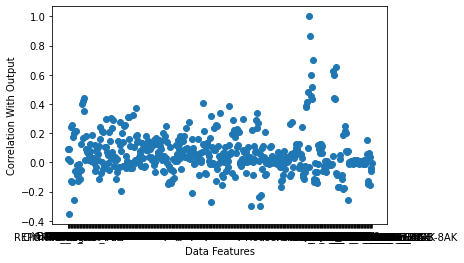

In [ ]:
plt.scatter(corr_values.index, corr_values['correlation'])
plt.xlabel("Data Features")
plt.ylabel("Correlation With Output")

Histogram of the correlation of KWH with other variables. 

(array([  1.,   2.,   3.,   3.,   7.,  14.,  23.,  35.,  60., 112.,  61.,
         54.,  40.,  21.,  19.,  16.,  10.,   6.,   3.,   5.,   6.,   1.,
          1.,   0.,   2.,   1.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,
          0.,   1.]),
 array([-0.35312325, -0.31446259, -0.27580192, -0.23714126, -0.1984806 ,
        -0.15981993, -0.12115927, -0.0824986 , -0.04383794, -0.00517727,
         0.03348339,  0.07214406,  0.11080472,  0.14946538,  0.18812605,
         0.22678671,  0.26544738,  0.30410804,  0.34276871,  0.38142937,
         0.42009003,  0.4587507 ,  0.49741136,  0.53607203,  0.57473269,
         0.61339336,  0.65205402,  0.69071469,  0.72937535,  0.76803601,
         0.80669668,  0.84535734,  0.88401801,  0.92267867,  0.96133934,
         1.        ]),
 <a list of 35 Patch objects>)

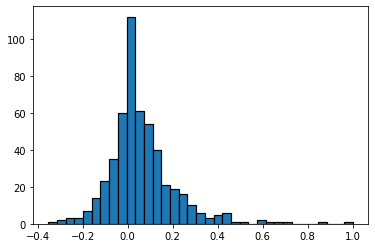

In [ ]:
plt.hist(corr_values['correlation'], bins = 35, edgecolor='black', linewidth=1.2)

# 4. Random Forest Regressor

Importing the Libraries

In [ ]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score, mean_squared_error
from time import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score, GridSearchCV

Preparing the data and splitting into train set and test set

In [ ]:
# Extract features and labels
Y = data_public['KWH']
X = data_public.drop('KWH', axis = 1)

# List of features for later use
X_columns = list(X.columns)

# Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [ ]:
Y.head()

0    18466.0
1     5148.0
2     2218.0
3    10015.0
4     2869.0
Name: KWH, dtype: float64

In [ ]:
print('Training Features Shape (X_train):', X_train.shape)
print('Training Labels Shape (y_train):', y_train.shape)
print('Testing Features Shape (X_test):', X_test.shape )
print('Testing Labels Shape (y_test):', y_test.shape)

Training Features Shape (X_train): (9666, 511)
Training Labels Shape (y_train): (9666,)
Testing Features Shape (X_test): (2417, 511)
Testing Labels Shape (y_test): (2417,)


Defining the parameters

In [ ]:
param_dict_rfr = {'max_depth' : range(1,10,5),
                  'n_estimators': [50, 100, 150],
                  'max_features': ['auto', 'sqrt', 'log2'],
                  'criterion' :['squared_error'] } #n_estimators = 100, #'criterion' : ['squared_error'], max_depth=None, min_samples_split=2, max_features=1.0, }

model = RandomForestRegressor()

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

Fitting the model

In [ ]:
rfr_old = model
rfr_old.fit(X_train,y_train)

RandomForestRegressor()

Using GridSearchCV for optimum parameter selection

In [ ]:
grid_rf = GridSearchCV(rfr_old, param_grid = param_dict_rfr, cv= cv, n_jobs = -1)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error'],
                         'max_depth': range(1, 10, 5),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 150]})

Looking at the best parameters

In [ ]:
grid_rf.best_params_

{'criterion': 'squared_error',
 'max_depth': 6,
 'max_features': 'auto',
 'n_estimators': 50}

Giving the new best parameters to the model

In [ ]:
rfr = RandomForestRegressor(n_estimators= grid_rf.best_params_['n_estimators'],
                               criterion = grid_rf.best_params_['criterion'], 
                               max_depth = grid_rf.best_params_['max_depth'], 
                               max_features = grid_rf.best_params_['max_features'], 
                               random_state=42)

Finding the training time, testing time, MSE and R2 Score

In [ ]:
regressor = [rfr]

for model in regressor[:]:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    y_pred = model.predict(X_test)
    predict_time = time()-start   
    print(model)
    print("\t Training time: %0.3fs" % train_time)
    print("\t Prediction time: %0.3fs" % predict_time)
    print("\t Mean Squared error: ", mean_squared_error(y_test, y_pred))
    print("\t R2 score:", r2_score(y_test, y_pred))

RandomForestRegressor(max_depth=6, n_estimators=50, random_state=42)
	 Training time: 11.420s
	 Prediction time: 11.437s
	 Mean Squared error:  6323352.602906706
	 R2 score: 0.8748384245773435


Feature Importances <br>
Finding the variables contributing the most towards the prediction of electricity consumption

In [ ]:
# Findin numerical feature importances
importances = list(rfr.feature_importances_)

feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(X_columns, importances)]


# Sorting the feature importances with the most important feature at the top
feature_importances = sorted(feature_importances, key = lambda i: i[1], reverse = True)

[print('Column: {:20} Importance: {}'.format(*j)) for j in feature_importances];

Column: DOLLAREL             Importance: 0.85117
Column: REPORTABLE_DOMAIN    Importance: 0.05115
Column: HDD50                Importance: 0.0241
Column: DIVISION             Importance: 0.01293
Column: NWEIGHT              Importance: 0.00649
Column: REGIONC              Importance: 0.00546
Column: HEATROOM             Importance: 0.00363
Column: HDD65                Importance: 0.00357
Column: OTHROOMS             Importance: 0.00282
Column: TOTALDOL             Importance: 0.00278
Column: TOTHSQFT             Importance: 0.00213
Column: GND_HDD65            Importance: 0.00173
Column: DOLELOTH             Importance: 0.00162
Column: GALLONLPOTH          Importance: 0.00162
Column: GALLONLP             Importance: 0.00156
Column: TOTALDOLOTH          Importance: 0.00155
Column: HDD30YR              Importance: 0.00142
Column: TOTCSQFT             Importance: 0.00122
Column: TOTALDOLCOL          Importance: 0.00113
Column: OVEN                 Importance: 0.00108
Column: NCOMBATH     

Finding the most important features

In [ ]:
feature_importances = [feature for feature in feature_importances if feature[1] >= 0.001]
[print('Column: {:20} Importance: {}'.format(*j)) for j in feature_importances];

Column: DOLLAREL             Importance: 0.85117
Column: REPORTABLE_DOMAIN    Importance: 0.05115
Column: HDD50                Importance: 0.0241
Column: DIVISION             Importance: 0.01293
Column: NWEIGHT              Importance: 0.00649
Column: REGIONC              Importance: 0.00546
Column: HEATROOM             Importance: 0.00363
Column: HDD65                Importance: 0.00357
Column: OTHROOMS             Importance: 0.00282
Column: TOTALDOL             Importance: 0.00278
Column: TOTHSQFT             Importance: 0.00213
Column: GND_HDD65            Importance: 0.00173
Column: DOLELOTH             Importance: 0.00162
Column: GALLONLPOTH          Importance: 0.00162
Column: GALLONLP             Importance: 0.00156
Column: TOTALDOLOTH          Importance: 0.00155
Column: HDD30YR              Importance: 0.00142
Column: TOTCSQFT             Importance: 0.00122
Column: TOTALDOLCOL          Importance: 0.00113
Column: OVEN                 Importance: 0.00108
Column: NCOMBATH     

Plotting the variables and the corresponding importance

Text(0.5, 1.0, 'Variable Importances')

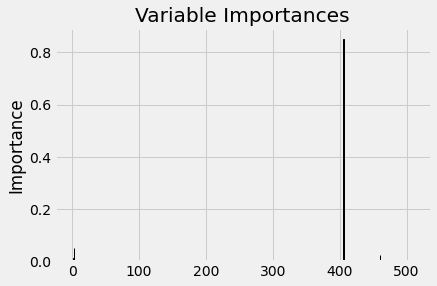

In [ ]:
# Reset style 
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, color = 'r', edgecolor = 'k', linewidth = 1)

# Tick labels for x axis
# plt.xticks(x_values, X_columns, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance')
# plt.xlabel('Variable')
plt.title('Variable Importances')

Again sorting the features on the basis of importance

In [ ]:
# Listing features sorted from most to least important

sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
print(len(sorted_importances))

23


Finding the variables' cumulative importance

In [ ]:
# Find number of features for cumulative importance of 95%

cumulative_importances = np.cumsum(sorted_importances)
imp_features_count =  np.where(cumulative_importances > 0.97)[0][0] + 1

print('Number of features for 95% importance:',imp_features_count)

Number of features for 95% importance: 14


In [ ]:
# Taking the column names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:imp_features_count]]

# Taking the columns of the most important features
important_indices = [X_columns.index(feature) for feature in important_feature_names]

# Generating training and testing sets containing only the important features
important_X_train = X_train.iloc[:, important_indices]
important_X_test = X_test.iloc[:, important_indices]

print('Important train features(important_X_train) shape:', important_X_train.shape)
print('Important test features(important_X_test) shape:', important_X_test.shape)

Important train features(important_X_train) shape: (9666, 14)
Important test features(important_X_test) shape: (2417, 14)


In [ ]:
# Train the expanded model on only the important features
rfr.fit(important_X_train, y_train);

Again running Random Forest Regressor (rfr) model on important columns only

In [ ]:
for model in regressor[:]:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    # start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start 
    # param_grid = param_dict_rfr   
    print(model)
    print("\t Training time: %0.3fs" % train_time)
    print("\t Prediction time: %0.3fs" % predict_time)
    # print("\tExplained variance: ", explained_variance_score(y_test, y_pred))
    # print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\t Mean Squared error: ", mean_squared_error(y_test, y_pred))
    print("\t R2 score:", r2_score(y_test, y_pred))

RandomForestRegressor(max_depth=6, n_estimators=50, random_state=42)
	 Training time: 12.890s
	 Prediction time: 12.909s
	 Mean Squared error:  6323352.602906706
	 R2 score: 0.8748384245773435


In [ ]:
# print(important_feature_names)

df_concat = pd.concat([important_X_train, y_train], axis=1)
corr_values_important = df_concat[df_concat.columns[1:]].corr()[Y_colname][:]

corr_values.rename(columns = {'KWH' : 'correlation'}, inplace = True)
print(corr_values_important)

                        KWH
REPORTABLE_DOMAIN  0.092888
HDD50             -0.116777
DIVISION           0.025844
NWEIGHT            0.003103
REGIONC            0.093433
HEATROOM           0.402005
HDD65             -0.134628
OTHROOMS           0.350746
TOTALDOL           0.631271
TOTHSQFT           0.411081
GND_HDD65         -0.182833
DOLELOTH           0.700779
GALLONLPOTH        0.134879
KWH                1.000000


Plotting heatmap of the correlation

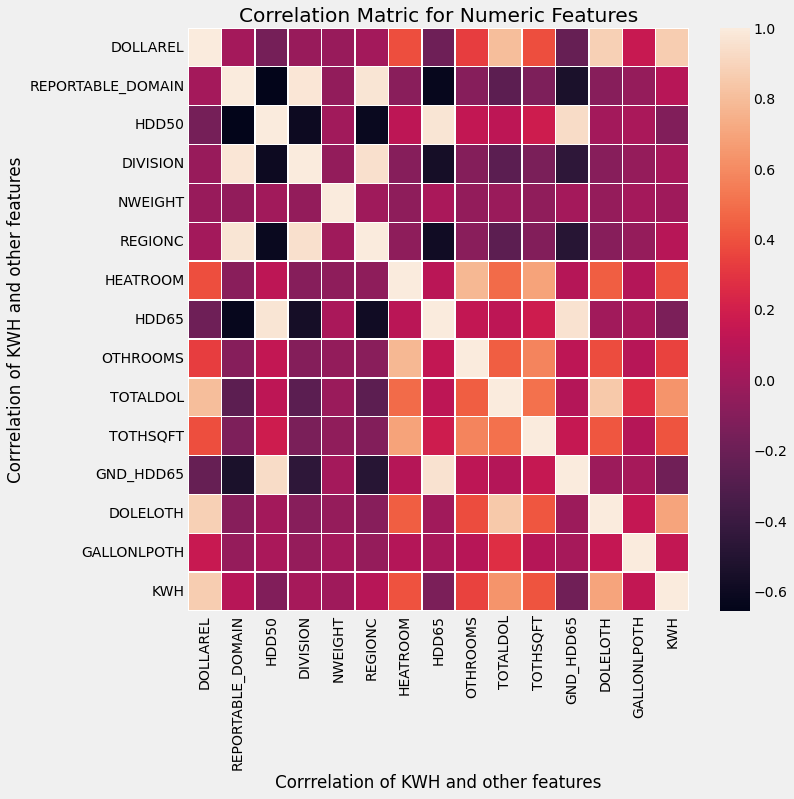

In [ ]:
correlation_matrix = df_concat.corr(method = 'pearson')

fig, ax = plt.subplots(figsize=(10,10))      
sns.heatmap(correlation_matrix, annot=False, linewidths=.5, ax=ax)
plt.title('Correlation Matric for Numeric Features')
plt.xlabel('Corrrelation of KWH and other features')
plt.ylabel('Corrrelation of KWH and other features')
plt.show()

From the heatmap, it can be observed that the correlation of KWH is high with certain variables than others.

# Conclusion

The features contributing the most towards the prediction of the electricity consumption is obtained with several steps of data cleaning, processing and feature engineering. <br>
Random Forest Regressor is giving fair output with R2 score of 0.875. With more data exploration and manipulation, more optimised prediction can be obtained. <br>  




### Further tasks

Other models such as Neural Networks can be used for the prediction. <br>
The features can be dugged deep with more EDA and by using libraries such as FeatureSelector to further improve the model and working more on feature importance. 




### References

*  https://towardsdatascience.com/a-feature-selection-tool-for-machine-learning-in-python-b64dd23710f0
*   https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/
*   https://www.youtube.com/watch?v=ioXKxulmwVQ&t=0s
*   https://towardsdatascience.com/a-feature-selection-tool-for-machine-learning-in-python-b64dd23710f0

*   https://machinelearninghd.com/gridsearchcv-hyperparameter-tuning-sckit-learn-regression-classification/

*  https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd
